In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# 구 버전 jupyter에서의 그래프 시각화

plt.rc('font',family='NanumGothic')

plt.rc("axes",unicode_minus=False)
# 마이너스 폰트 깨짐 방지

%config InlineBackend.figure_format = 'retina'
# 폰트를 선명하게

In [11]:
default_path = "drive/MyDrive/Colab Notebooks/"

---
genre_gn_all.json

In [58]:
genre_gn_all = pd.read_json(default_path+'genre_gn_all.json',typ='series')

In [64]:
# make genre_gn_all as data frame with code, name columns
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns={'index' : 'gnr_code'})

In [65]:
# 254 categories
genre_gn_all.sample()

,gnr_code,gnr_name
18,GN0400,R&B/Soul


In [15]:
# filter tail of code is '00', which is a big category
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']

In [61]:
# 30 big categories
gnr_code.sample()

,gnr_code,gnr_name,join_code
56,GN0900,POP,GN09


In [17]:
# filter tail of code is not '00', which is a detail category
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
# 224 detail categories
dtl_gnr_code.sample()

,dtl_gnr_code,dtl_gnr_name,join_code
75,GN1010,'70,GN10


In [19]:
# extract 4 head char of code => genre code
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# make it tree by extracted genre code
gnr_code_tree = pd.merge(gnr_code,dtl_gnr_code, how = 'left', on = 'join_code')


In [67]:
gnr_code_tree.sample()

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
106,GN1500,OST,GN15,GN1504,국내드라마


In [68]:
# see code GN0900 POP
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN0900'].sample()

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
53,GN0900,POP,GN09,GN0906,'80-'90


---
song_meta.json

In [22]:
song_meta = pd.read_json(default_path+'song_meta.json',typ = 'frame')

In [69]:
song_meta.sample()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
176975,"[GN0105, GN0101]",20140430,미안해 엄마,2307572,[745769],미안해 엄마,[GN0100],[박정은],176975


In [24]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


In [25]:
# extract id, big genre list
song_gnr_map = song_meta.loc[:,["id","song_gn_gnr_basket"]]

# match gen code and id 1 by 1 as array
song_gnr_map_unnest = np.dstack(
  (
    # extract id, gen list length as array
    # and repeat id as value of list
    np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))),
    
    # get gen lists as array and merge as one list (duplicate allowed)
    np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
  )
)

In [26]:
# make it dataframe
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)

# change column names
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# remove unnest
del song_gnr_map_unnest

In [70]:
song_gnr_map.sample()

,song_id,gnr_code
482141,425295,GN2200


In [71]:
# make genre per song table : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')
song_gnr_count.sample()

,song_id,mapping_gnr_cnt
289388,360851,1


In [72]:
# make song per genre number table : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = "매핑된 곡 수")
gnr_song_count.sample()

,mapping_gnr_cnt,매핑된 곡 수
0,1,612806


In [73]:
# add percentage column
gnr_song_count.loc[:,'비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100,2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수','매핑된 곡 수','비율(%)']].sample()

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69


---
Most genres

In [31]:
# make genre per song number table : gnr_count
gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')
gnr_count.sample()

,gnr_code,song_cnt
6,GN0700,12673


In [32]:
# indicate gnr_name
gnr_count = pd.merge(gnr_count,gnr_code.loc[:,['gnr_code','gnr_name']], how = 'left', on = 'gnr_code')
gnr_count.sample()

,gnr_code,song_cnt,gnr_name
18,GN1900,21413,J-POP


In [33]:
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'
gnr_count.sample()

,gnr_code,song_cnt,gnr_name,gnr_code_name
5,GN0600,29690,록/메탈,GN0600 (록/메탈)


In [34]:
# drop rows which doesn't matched
gnr_count = gnr_count[['gnr_code_name','song_cnt']].dropna()
gnr_count.sample()

,gnr_code_name,song_cnt
0,GN0100 (발라드),56820


In [75]:
# sort by mapped song number, descedning
gnr_list_desc = gnr_count.sort_values('song_cnt',ascending=False).gnr_code_name
gnr_list_desc.sample()

16    GN1700 (재즈)
Name: gnr_code_name, dtype: object

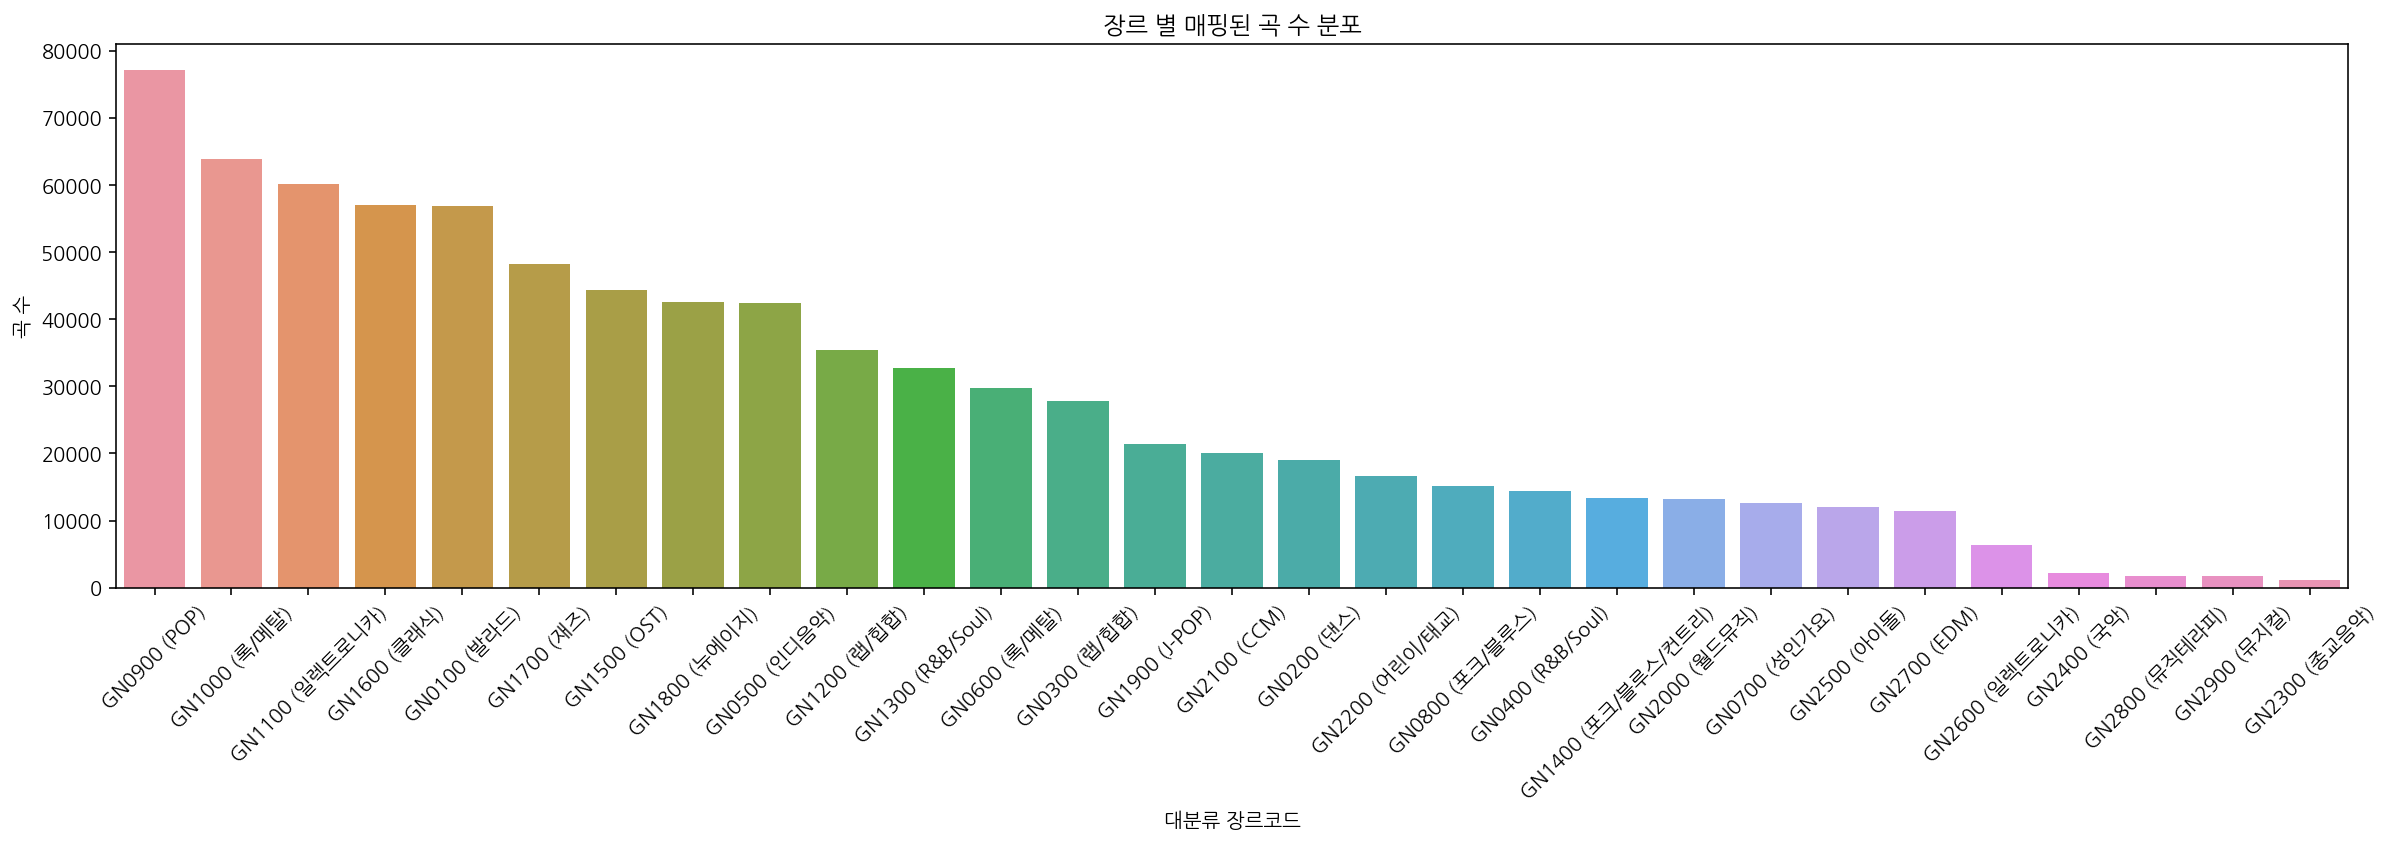

In [52]:
# plotting
plt.figure(figsize = (20, 5))
gnr_code_name_plot = sns.barplot(x='gnr_code_name',y='song_cnt',data=gnr_count,order=gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation=45)
plt.show()

---
Most years

In [39]:
# ignore warning
pd.options.mode.chained_assignment = None

In [76]:
# extract id and date
song_issue_date = song_meta[['id','issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)
song_issue_date.sample()

,id,issue_date
515034,515034,20190830


In [40]:
# extract year from date
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns={'id':'song_id'},inplace=True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)
song_issue_date.sample()

,song_id,issue_date,issue_year
237365,237365,20041031,2004


In [42]:
# filter 1990~
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

In [46]:
# song number per year
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')
issue_year_song_cnt.sample()

,issue_year,song_cnt
4,1994,3191


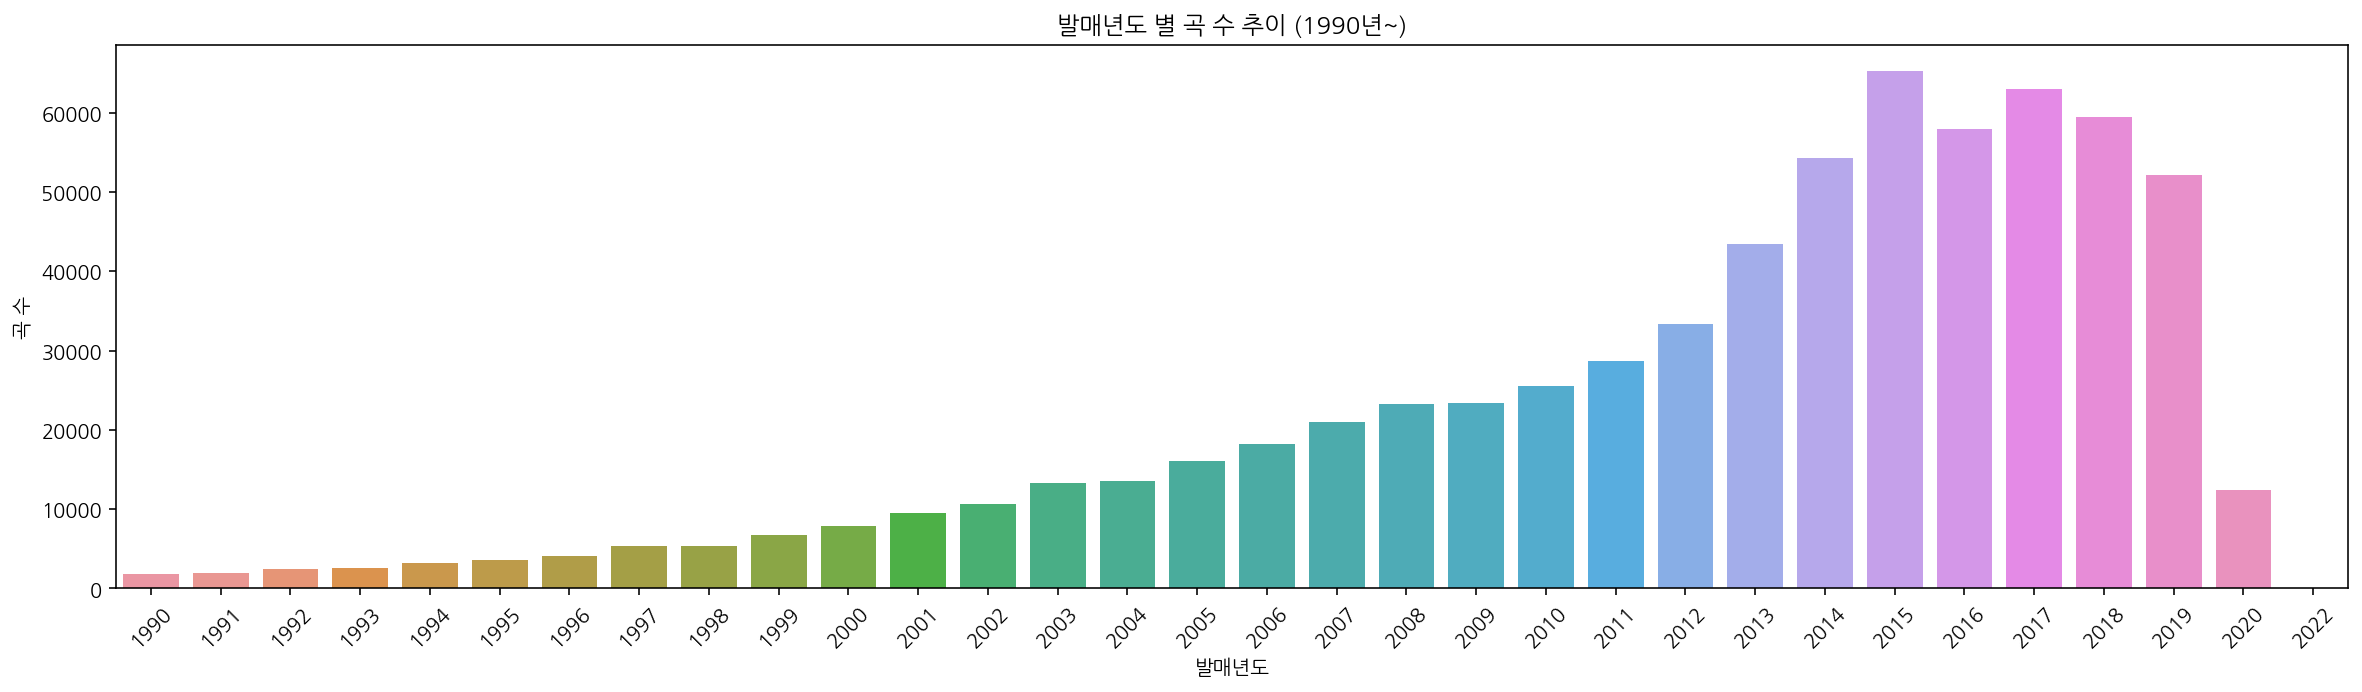

In [54]:
# plotting
plt.figure(figsize = (20, 5))
issue_year_song_cnt_plot = sns.barplot(x='issue_year',y='song_cnt', data = issue_year_song_cnt)
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation=45)
plt.show()

---
train.json

In [59]:
train = pd.read_json(default_path+'train.json',typ='frame')

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [78]:
# extract id and songs
plylst_song_map = train[['id','songs']]
plylst_song_map.sample()

,id,songs
76599,27289,"[517016, 213942, 322928, 250632, 484435, 68663..."


In [82]:
# 1 by 1 match playlist id and song id (duplicated)
plylst_song_map_unnest = np.dstack(
  (
    np.repeat(plylst_song_map.id.values,list(map(len,plylst_song_map.songs))),
    np.concatenate(plylst_song_map.songs.values)
  )
)

plylst_song_map_unnest

array([[[ 61281, 525514],
        [ 61281, 129701],
        [ 61281, 383374],
        ...,
        [100389, 640239],
        [100389,  13759],
        [100389, 154078]]])

In [84]:
# make it dataframe
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0],columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

del plylst_song_map_unnest
plylst_song_map.sample()

,id,songs
3561495,109105,647228


In [ ]:
train_uniq_song_cnt = plylst_song_map.songs.nunique()
train_uniq_tag_cnt